In [148]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from ipywidgets import widgets
from ipywidgets import *
from IPython.display import display, HTML
from IPython.html import install_nbextension
plt.style.use('ggplot')


In [5]:
import gc
gc.collect()

853

In [6]:
%matplotlib inline

In [138]:
table_TOD = pd.read_csv('USD000000TOD.trades_20180514_092903.csv', sep=';')
table_TSTOM = pd.read_csv('USD000UTSTOM.trades_20180514_092903.csv', sep=';')
table_TOD.head()

,quantity,price,isBuy,ticks,origTimeHHMMSS,origTimeMicroSecs,fastId,fixId,tag779,tag52,...,srcPx,futStatus,priceInfo,dstPriceAdd,timePacket,timeCreate,timeStartPrepare,timeEndPrepare,delta,Unnamed: 21
0,10,6189000,1,NaN,70000,766582,168639238,-1,0,180514070000767140,...,0,-1,94484348479664,140219878265944,0.0,0.0,0.0,0.0,0,NaN
1,10,6189000,1,NaN,70000,770012,168639239,-1,0,180514070000770445,...,0,-1,94484348479664,140219878265944,0.0,0.0,0.0,0.0,0,NaN
2,9,6189000,1,NaN,70000,792681,168639242,-1,0,180514070000793141,...,0,-1,94484348479664,140219878265944,0.0,0.0,0.0,0.0,0,NaN
3,51,6189000,1,NaN,70001,157832,168639246,-1,0,180514070001158366,...,0,-1,94484348479664,140219878265944,0.0,0.0,0.0,0.0,0,NaN
4,1,6186750,0,NaN,70001,310769,168639247,-1,0,180514070001311246,...,0,-1,94484348479664,140219878265944,0.0,0.0,0.0,0.0,0,NaN


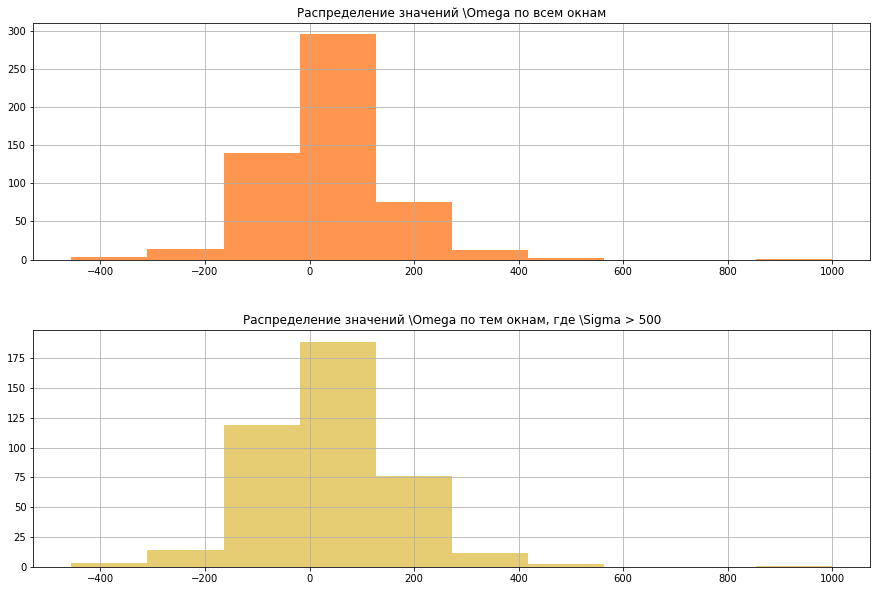

In [143]:
answer_TSTOM = my_func(table_TSTOM, 150)
answer_TSTOM.to_csv('answer_TSTOM.csv')

In [140]:
answer_TSTOM.head(15)

window_number     omega      sigma
origTimeHHMMSS origTimeMicroSecs                                    
70000          600900                         0  6.575581   0.038230
               623106                         0  6.575581  -0.382301
               681441                         0  6.575581  -0.038230
               716771                         0  6.575581  -0.152920
               772476                         0  6.575581  -0.382301
               779607                         0  6.575581   0.076460
               794958                         0  6.575581  -0.344071
               816862                         0  6.575581  -0.076460
               928041                         0  6.575581  -0.114690
70001          787697                         0  6.575581   1.070443
               973980                         0  6.575581   0.841063
70002          314496                         0  6.575581  -1.911506
               636614                         0  6.575581   0.496992
               784267                         0  6.575581  10.322134
70003          784579                         0  6.575581  -1.911506

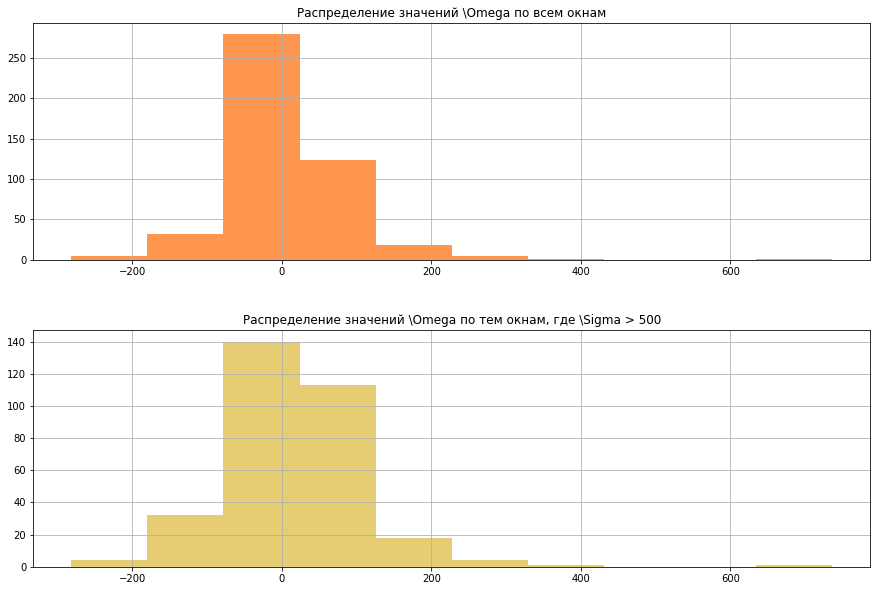

In [144]:
answer_TOD = my_func(table_TOD, 100)
answer_TOD.to_csv('answer_TOD.csv')

In [141]:
answer_TOD.head(20)

window_number      omega       sigma
origTimeHHMMSS origTimeMicroSecs                                      
70000          766582                         0 -29.736842   -3.912742
               770012                         0 -29.736842   -3.912742
               792681                         0 -29.736842   -3.521468
70001          157832                         0 -29.736842  -19.954986
               310769                         0 -29.736842    0.391274
               948730                         0 -29.736842  -19.563712
70002          271273                         0 -29.736842  -27.389197
               271959                         0 -29.736842    1.173823
70005          710032                         0 -29.736842   -0.391274
70007          267611                         0 -29.736842   19.563712
               667053                         0 -29.736842  -20.346260
               681553                         0 -29.736842    9.781856
               732237                         0 -29.736842  131.076870
               733366                         0 -29.736842  -37.171053
               737782                         0 -29.736842  -39.127424
               737993                         0 -29.736842  -19.563712
               753713                         0 -29.736842   58.691136
               768501                         0 -29.736842  -52.430748
70008          157334                         0 -29.736842   -1.565097
               808085                         0 -29.736842   -7.825485

### Я сделала виджет, чтобы удобнее было смотреть, как меняется распределение при разных значениях ширины окна

In [150]:
a = widgets.IntSlider(description='window_size (sec):', continuous_update=False, value=100, step=5, max=18000)

out = widgets.interactive_output(interactive_func, {'window_size': a})

display(widgets.VBox([widgets.HBox([a]), out]))
plt.show()


VBox(children=(HBox(children=(IntSlider(value=100, continuous_update=False, description='window_size (sec):', max=18000, step=5),)), Output()))

In [125]:
def my_func(table, window_size):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
    w_size = window_size*1000000 # microsec -> 1 min
    
    table.columns = map(lambda x: x.strip(), table.columns)

    # объединяю время в один столбец, чтобы временное окно разделяло данные корректно
    table['fulltime'] = table.apply(lambda x: x['origTimeHHMMSS']*1000000 + x['origTimeMicroSecs'], axis=1).astype('int64')

    # делаю объем заявки взвешенным
    table['w_quantity'] = table.apply(lambda x: x['quantity'] if x['isBuy'] == 1 else -x['quantity'], axis=1)

    grouped_by_time = table.groupby(['fulltime']).agg({'w_quantity': 'sum'}).reset_index()
    
    # рассчитываю, в какое окно попадет каждая из сделок
    min_time = table.fulltime.min()
    grouped_by_time['window_number'] = grouped_by_time.fulltime.apply(lambda x: (x - min_time) // w_size)
    
    # рассчитываю суммарный объем, количество сделок и \Omega по окнам
    grouped_by_window = grouped_by_time.groupby(by=['window_number']).agg({'w_quantity' : 'sum', 'window_number' : 'count'})
    grouped_by_window.columns = ['sum_quantity', 'w_size']
    grouped_by_window['omega'] = grouped_by_window.apply(lambda x: x.sum_quantity/x.w_size, axis=1)
    grouped_by_window['omega_shift'] = grouped_by_window.omega.shift().fillna(0)
    
    #вывод гистограммы
    grouped_by_window.hist('omega', ax=ax1, color=cm.rainbow(0.8))
    ax1.set_title('Распределение значений \Omega по всем окнам')
    # объединяю обратно c таблицей всех сделок
    common_df = grouped_by_time.join(grouped_by_window, on='window_number')

    # рассчитываю \Sigma методом абсолютной разности в виде:
    # sigma = delta(quantity)*omega_(i-1) + delta(omega)*quantity_(i-1)
    
    common_df['quantity_diff'] = common_df.w_quantity.diff().fillna(0)
    common_df['sigma'] = (common_df.quantity_diff*common_df.omega_shift + (common_df.omega-common_df.omega_shift)*common_df.w_quantity)/common_df.w_size

    common_df[common_df.sigma>500].groupby('window_number')['omega'].max().hist(ax=ax2, color=cm.rainbow(0.7))
    ax2.set_title('Распределение значений \Omega по тем окнам, где \Sigma > 500')
    # возвращаю обратно исходные колонки времени
    common_df = common_df.merge(table[['origTimeHHMMSS', 'origTimeMicroSecs', 'fulltime']], how='left', on='fulltime', suffixes='_r').drop_duplicates()
    
    common_df.set_index(['origTimeHHMMSS', 'origTimeMicroSecs'], inplace=True)
    return common_df[['window_number', 'omega', 'sigma']]

In [124]:
def interactive_func(window_size, filename='USD000UTSTOM.trades_20180514_092903.csv'):
    """
    Функция чисто для вывода гистограмм при изменении значения ползунка interact
    """
    table = pd.read_csv(filename, sep=';')
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
    w_size = window_size*1000000 # microsec -> 1 min
    
    table.columns = map(lambda x: x.strip(), table.columns)

    # объединяю время в один столбец, чтобы временное окно разделяло данные корректно
    table['fulltime'] = table.apply(lambda x: x['origTimeHHMMSS']*1000000 + x['origTimeMicroSecs'], axis=1).astype('int64')

    # делаю объем заявки взвешенным
    table['w_quantity'] = table.apply(lambda x: x['quantity'] if x['isBuy'] == 1 else -x['quantity'], axis=1)

    grouped_by_time = table.groupby(['fulltime']).agg({'w_quantity': 'sum'}).reset_index()
    
    # рассчитываю, в какое окно попадет каждая из сделок
    min_time = table.fulltime.min()
    grouped_by_time['window_number'] = grouped_by_time.fulltime.apply(lambda x: (x - min_time) // w_size)
    
    # рассчитываю суммарный объем, количество сделок и \Omega по окнам
    grouped_by_window = grouped_by_time.groupby(by=['window_number']).agg({'w_quantity' : 'sum', 'window_number' : 'count'})
    grouped_by_window.columns = ['sum_quantity', 'w_size']
    grouped_by_window['omega'] = grouped_by_window.apply(lambda x: x.sum_quantity/x.w_size, axis=1)
    grouped_by_window['omega_shift'] = grouped_by_window.omega.shift().fillna(0)
    
    #вывод гистограммы
    grouped_by_window.hist('omega', ax=ax1, color=cm.rainbow(0.8), bins=30)
    ax1.set_title('Распределение значений \Omega по всем окнам. Ширина окна {}'.format(str(window_size)))
    # объединяю обратно c таблицей всех сделок
    common_df = grouped_by_time.join(grouped_by_window, on='window_number')

    # рассчитываю \Sigma методом абсолютной разности в виде:
    # sigma = delta(quantity)*omega_(i-1) + delta(omega)*quantity_(i-1)
    
    common_df['quantity_diff'] = common_df.w_quantity.diff().fillna(0)
    common_df['sigma'] = (common_df.quantity_diff*common_df.omega_shift + (common_df.omega-common_df.omega_shift)*common_df.w_quantity)/common_df.w_size

    common_df[common_df.sigma>500].groupby('window_number')['omega'].max().hist(ax=ax2, bins=30, color=cm.rainbow(0.6))
    ax2.set_title('Распределение значений \Omega по тем окнам, где \Sigma > 500. Ширина окна {}'.format(str(window_size)))